# **Importing required libraries**

In [0]:
import keras 
import numpy as np
import os
import random
from keras.layers import ConvLSTM2D ,Flatten ,Dense ,Input ,Dropout
from google.colab import drive
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score ,recall_score ,f1_score ,roc_auc_score ,confusion_matrix
import matplotlib.pyplot as plt
from keras.models import Model ,load_model
import keras.backend as K

This line of code is for mounting your drive(people who wants use their colab to train the model)

In [4]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Note:the directories are to be changed based on where you save your dataset.<br/>
In my case the training set is at the below mentioned directory

In [0]:
train_dir = '/content/gdrive/My Drive/project_pose/pose'
classes = os.listdir(train_dir)

The below piece of code creates a dictionary which maps the directories of folders with the corresponding labels

In [0]:
def create_dict(train_dir ,classes = None):
    if classes is None:
        classes = os.listdir(train_dir)
    counter = 0
    dict_ = {}
    for i ,class_ in enumerate(classes):
        past_counter = counter
        print('class {} is {}'.format(i,classes[i]))
        class_dir = os.path.join(train_dir ,class_)
        folders = os.listdir(class_dir)
        for folder in folders:
            folder_dir = os.path.join(class_dir ,folder)
            counter = counter+1
            dict_[folder_dir] = i
        print('{} are loaded from class {}'.format(counter-past_counter,i))
    print('total of {} arrays are loaded'.format(counter))
    return dict_

In [7]:
classes = ['drumming' ,'punching' ,'HorseRace']
dict_ = create_dict(train_dir ,classes = classes)

class 0 is drumming
1987 are loaded from class 0
class 1 is punching
1273 are loaded from class 1
class 2 is HorseRace
1534 are loaded from class 2
total of 4794 arrays are loaded


As you observe ,there is some class imbalance of our data.<br/>
Drumming has quiet a many datapoints followed by punching and the followed by Horse race.<br/>
So to deal with the imbalanace ,we use focal loss.

In [0]:
def my_loss(alpha ,gamma):
    def focal_loss(y_true ,y_pred):
        y_pred = K.clip(y_pred ,1e-8 ,1-1e-8)
        loss = -alpha*y_true*(K.pow((1-y_pred),gamma))*K.log(y_pred)
        return loss
    return focal_loss

Defining our model

In [9]:
input_ = Input((20 ,16 ,21 ,17))
cl1 = ConvLSTM2D(filters=32, kernel_size=(3, 4) ,activation = 'elu' ,kernel_initializer = 'glorot_uniform' ,return_sequences=True)(input_)
Drp1 = Dropout(0.2)(cl1)
cl2 = ConvLSTM2D(filters=64, kernel_size=(3, 4) ,activation = 'elu' ,kernel_initializer = 'glorot_uniform' ,return_sequences=True)(Drp1)
Drp2 = Dropout(0.2)(cl2)
cl3 = ConvLSTM2D(filters=128, kernel_size=(3, 4) ,activation = 'elu' ,kernel_initializer = 'glorot_uniform' ,return_sequences=True)(Drp2)
Drp3 = Dropout(0.2)(cl3)
cl4 = ConvLSTM2D(filters=256, kernel_size=(2, 4) ,activation = 'elu' ,kernel_initializer = 'glorot_uniform' ,return_sequences=True)(Drp3)
Drp4 = Dropout(0.2)(cl4)
cl5 = ConvLSTM2D(filters=512, kernel_size=(3, 3) ,activation = 'elu' ,kernel_initializer = 'glorot_uniform' ,return_sequences=True)(Drp4)
flatten = Flatten()(cl5)
d1 = Dense(256 ,activation = 'elu')(flatten)
softmax_layer = Dense(3 ,activation = 'softmax')(d1)
model = Model(input = input_ ,output = softmax_layer)
model.compile(optimizer = Adam(lr = 0.000001) ,loss = my_loss(2.0 ,3.0) ,metrics = ['acc'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [10]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20, 16, 21, 17)    0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 20, 14, 18, 32)    75392     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 14, 18, 32)    0         
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 20, 12, 15, 64)    295168    
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 12, 15, 64)    0         
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 20, 10, 12, 128)   1180160   
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 10, 12, 128)   0   

This below code contains some functions which are used in splitting the data into test and train and training the model.<br/>
Note:Again the save directory is to be manipulated according to your need.


In [0]:
def create_test_and_train(train_dir ,classes = None):
    fnames = get_fnames(train_dir ,classes)
    random.shuffle(fnames)
    test = fnames[:200]
    del fnames[:200]
    print('test set is created')
    return test,fnames
def get_fnames(train_dir ,classes = None):
    if classes is None:
        classes = os.listdir(train_dir)
    fnames = []
    for class_ in classes:
        class_dir  =os.path.join(train_dir ,class_)
        folders = os.listdir(class_dir)
        for folder in folders:
            folder_dir = os.path.join(class_dir ,folder)
            fnames.append(folder_dir)
    return fnames
def get_encoding(num ,num_classes = 3):
    encoding = np.zeros(num_classes)
    encoding[num] = 1
    return encoding
def train(fnames ,dict_ ,model ,batch_size = 70):
    batches = len(fnames)//batch_size
    print(batches)
    for batch in range(batches):
        X = []
        Y = []
        try:
            fdirs = fnames[batch*batch_size:(batch+1)*batch_size]
        except:
            fdirs = fnames[batch*batch_size:]
        print('creating X,Y for batch no {}...'.format(batch))
        for fdir in fdirs:
            files = os.listdir(fdir)
            x=[]
            for file_ in files:
                arr = np.load(os.path.join(fdir ,file_))
                x.append(np.squeeze(arr ,axis = 0))
            print('{} loaded'.format(fdir))
            if get_encoding(dict_.get(fdir)) is not None:
                X.append(x)
                Y.append(get_encoding(dict_.get(fdir)))
            else:
                print('None label encounteres')
        X = np.asarray(X)
        Y = np.asarray(Y)
        print(X.shape)
        print('batch {}'.format(batch))
        model.fit(X ,Y ,verbose = 1 ,batch_size = 2 ,epochs = 20)
        model.save('/content/gdrive/My Drive/project_pose/model.h5')
    return test

In [0]:
test ,fnames = create_test_and_train(train_dir ,classes = classes)
test = train(fnames ,dict_ ,model)

Loading the trained model.

In [0]:
model = load_model('/content/gdrive/My Drive/project_pose/model.h5' ,custom_objects = {'focal_loss' : my_loss(2.0 ,1.5)})

Creating test set from test names that are extracted from dataset earlier

In [14]:
X_test = []
Y_test = []
for  i,folder in enumerate(test):
    files =os.listdir(folder)
    x = []
    for file_ in files:
        file_dir = os.path.join(folder ,file_ )
        arr = np.load(file_dir)
        x.append(np.squeeze(arr ,axis = 0))
    print('{} {} loaded'.format(i ,folder))
    X_test.append(x)
    Y_test.append(dict_.get(folder))
X_test = np.asarray(X_test)
Y_test = np.asarray(Y_test)

0 /content/gdrive/My Drive/project_pose/pose/HorseRace/folder752 loaded
1 /content/gdrive/My Drive/project_pose/pose/drumming/folder1287 loaded
2 /content/gdrive/My Drive/project_pose/pose/punching/folder1058 loaded
3 /content/gdrive/My Drive/project_pose/pose/HorseRace/folder944 loaded
4 /content/gdrive/My Drive/project_pose/pose/HorseRace/folder771 loaded
5 /content/gdrive/My Drive/project_pose/pose/drumming/folder321 loaded
6 /content/gdrive/My Drive/project_pose/pose/drumming/folder252 loaded
7 /content/gdrive/My Drive/project_pose/pose/drumming/folder602 loaded
8 /content/gdrive/My Drive/project_pose/pose/punching/folder661 loaded
9 /content/gdrive/My Drive/project_pose/pose/HorseRace/folder873 loaded
10 /content/gdrive/My Drive/project_pose/pose/HorseRace/folder542 loaded
11 /content/gdrive/My Drive/project_pose/pose/drumming/folder366 loaded
12 /content/gdrive/My Drive/project_pose/pose/HorseRace/folder499 loaded
13 /content/gdrive/My Drive/project_pose/pose/HorseRace/folder457 

Converting them to encodings


In [0]:
Y_true_en = []
for i in range(Y_test.shape[0]):
    Y_true_en.append(get_encoding(Y_test[i]))
Y_true_en = np.asarray(Y_true_en)

Evaluating the trained model.<br/>
We got around 92% of accuracy as of now.

In [17]:
model.evaluate(X_test ,Y_true_en)

200/200 [==============================] - 13s 65ms/step


[0.08056090474128723, 0.9200000166893005]

In [0]:
y_pred = model.predict(X_test)

In [0]:
def decode(arr):
    m = arr.shape[0]
    arr_ = np.zeros(m)
    for i in range(m):
        arr_[i] = np.argmax(arr[i])
    return arr_
y_pred_de = decode(y_pred)

In [20]:
Y_test

array([2, 0, 1, 2, 2, 0, 0, 0, 1, 2, 2, 0, 2, 2, 2, 2, 0, 1, 0, 0, 0, 2,
       1, 1, 0, 0, 1, 1, 2, 2, 2, 0, 0, 2, 2, 1, 1, 0, 2, 2, 2, 1, 1, 0,
       2, 1, 1, 2, 2, 2, 0, 1, 0, 1, 0, 2, 2, 2, 0, 1, 0, 2, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2,
       2, 2, 2, 1, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 1, 1, 2, 0, 0, 2, 0, 1,
       0, 1, 1, 0, 0, 2, 2, 0, 1, 2, 2, 2, 0, 0, 0, 1, 1, 2, 2, 0, 0, 2,
       1, 2, 2, 2, 1, 0, 2, 0, 1, 0, 0, 2, 0, 1, 1, 0, 0, 1, 0, 0, 2, 2,
       0, 2, 1, 2, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 1, 0, 1,
       0, 2, 2, 2, 1, 0, 0, 0, 2, 2, 0, 0, 2, 0, 1, 2, 2, 0, 1, 0, 0, 2,
       0, 0])

Calculating some standard metrics

In [21]:
acc_score = accuracy_score(Y_test ,y_pred_de)
pre_score = precision_score(Y_test ,y_pred_de,average = 'micro')
recall = recall_score(Y_test ,y_pred_de ,average = 'micro')
f1 = f1_score(Y_test ,y_pred_de ,average = 'micro')

print('accuracy score : {}'.format(acc_score))
print('precision score : {}'.format(pre_score))
print('recall score : {}'.format(recall))
print('f1 score : {}'.format(f1))

accuracy score : 0.92
precision score : 0.92
recall score : 0.92
f1 score : 0.92


Plotting the confusion matrix.

[[80  3  3]
 [ 8 37  0]
 [ 1  1 67]]


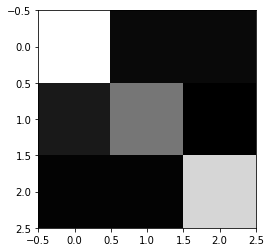

In [22]:
k = confusion_matrix(Y_test ,y_pred_de)
print(k)
plt.imshow(k ,cmap = 'gray')